In [ ]:
!pip install catboost
!pip install lightgbm

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import VotingRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error as mae

Считываем данные

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Train.csv")

train_df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,560,NaN,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,4510000
1,1,2011-1,667,NaN,10,50,2,1,25.0,NaN,...,0,0,0,0,0,0,0,0,0,13231000
2,2,2011-1,90,0.0,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,2008000
3,3,2011-1,94,1.0,3,62,3,1,30.0,NaN,...,0,0,0,0,0,0,0,0,0,12680000
4,4,2011-1,232,0.0,3,60,3,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,3335000


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Test.csv")

test_df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,2012-3,459,NaN,1,60,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,2012-3,344,1.0,10,52,2,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,100002,2012-3,585,0.0,4,54,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100003,2012-3,494,NaN,2,52,2,1,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,2012-3,622,1.0,9,60,3,1,15.0,NaN,...,0,0,0,0,0,0,0,0,0,0


### То, что выглядит логично но убивает скор на кегле (абсолютно не понимаю почему)

Проверяем данные на выбросы

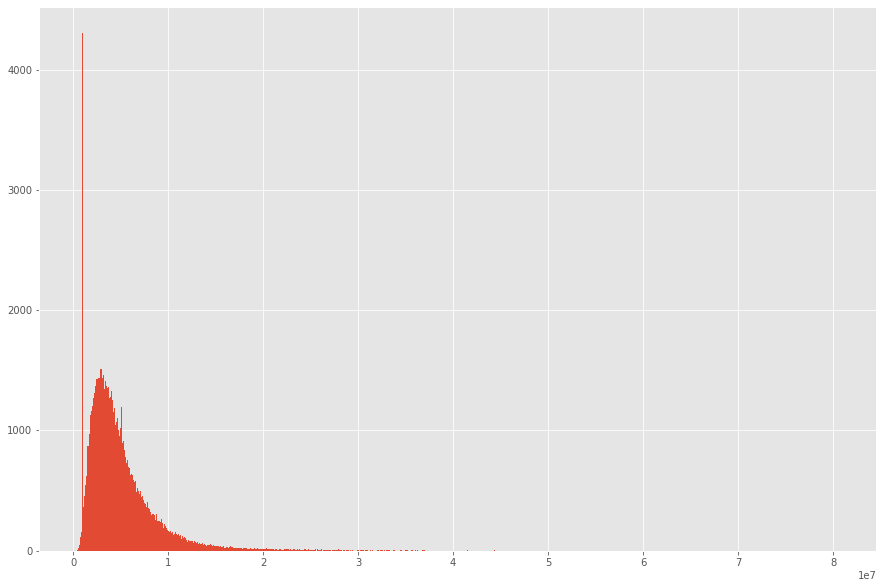

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(train_df.price, bins=1000);

По гистограме понятно, что присутсвует 2 выброса. Какая-то цена встречается слишком часто (найдем это значение и удалим его из выборки), а также обрежем хвост со слишком большими ценами.

In [ ]:
most_frequently_encountered = train_df.price.mode()[0]
print(f'Самое часто встречаемое значение: {most_frequently_encountered}')
train_df = train_df[(train_df.price != most_frequently_encountered) & (train_df.price < 2e+7)]

Самое часто встречаемое значение: 1000000


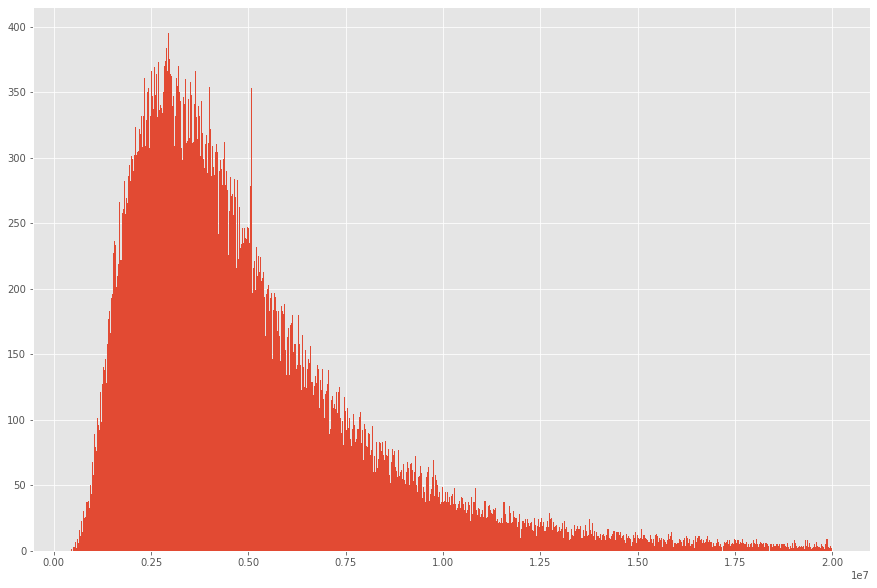

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(train_df.price, bins=1000);

Получем достаточно приятную гистограмму цены, распределенной по хи-квадрат

Далее проведем заполнение пустых значений и приведем все к одному типу

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94563 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          94563 non-null  int64  
 1   date        94563 non-null  object 
 2   street_id   94563 non-null  int64  
 3   build_tech  66399 non-null  float64
 4   floor       94563 non-null  int64  
 5   area        94563 non-null  int64  
 6   rooms       94563 non-null  int64  
 7   balcon      94563 non-null  int64  
 8   metro_dist  89915 non-null  float64
 9   g_lift      66219 non-null  float64
 10  n_photos    94563 non-null  int64  
 11  kw1         94563 non-null  int64  
 12  kw2         94563 non-null  int64  
 13  kw3         94563 non-null  int64  
 14  kw4         94563 non-null  int64  
 15  kw5         94563 non-null  int64  
 16  kw6         94563 non-null  int64  
 17  kw7         94563 non-null  int64  
 18  kw8         94563 non-null  int64  
 19  kw9         94563 non-nul

Переводим дату в месяцы и преобразуем к формату *int* 

In [ ]:
train_df.date = (pd.DatetimeIndex(train_df.date).year - pd.DatetimeIndex(train_df.date).year.min()) * 12 + pd.DatetimeIndex(train_df.date).month
test_df.date = (pd.DatetimeIndex(test_df.date).year - pd.DatetimeIndex(train_df.date).year.min())* 12 + pd.DatetimeIndex(test_df.date).month

Меняем *NaN* на медианное значение для **build_tech** и **g_lift** (чтобы не появлялось новое значение 0.5) и на среднее значение для **metro_dist** (практика показала что так работает лучше)

In [ ]:
train_df.build_tech = train_df.build_tech.fillna(train_df.build_tech.median()).astype('Int64')
test_df.build_tech = test_df.build_tech.fillna(test_df.build_tech.median()).astype('Int64')

train_df.g_lift = train_df.g_lift.fillna(train_df.g_lift.median()).astype('Int64')
test_df.g_lift = test_df.g_lift.fillna(test_df.g_lift.median()).astype('Int64')

train_df.metro_dist = train_df.metro_dist.fillna(train_df.metro_dist.mean())
test_df.metro_dist = test_df.metro_dist.fillna(test_df.metro_dist.mean())

Проверяем корреляциию признаков с метками

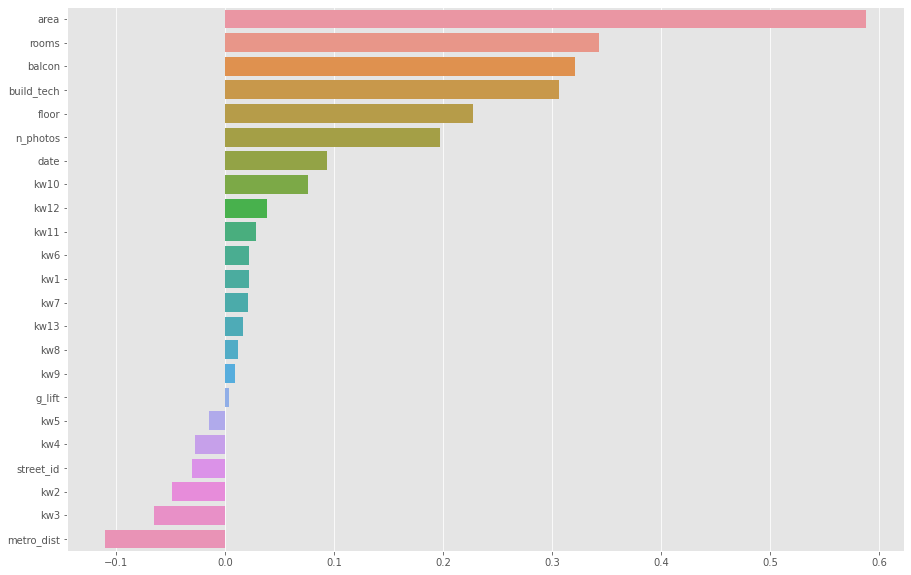

In [ ]:
correlations = train_df.drop(['price', 'id'], axis=1).corrwith(train_df.price).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Удалим признаки, корреляция с которыми меньше 0.1

In [ ]:
train_df = train_df.drop(['date', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'g_lift'], axis=1)
test_df = test_df.drop(['date', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'g_lift'], axis=1)

Считаем среднюю цену на квартиры на каждой улице

In [ ]:
(train_df.groupby("street_id")["price"].median().reset_index().sort_values("price"))

,street_id,price
387,387,1225500.0
499,499,1278500.0
105,105,1347500.0
535,535,1431000.0
525,525,1556500.0
...,...,...
255,255,11103000.0
430,430,11209000.0
667,667,11834000.0
94,94,14008000.0


Получем, что в зависимости от **street_id**, растет цена на квартиры. Пробуем задать новые значения для **street_id** (чем выше значение, тем элитнее это улица и тем больше средняя цена на квартиры)

In [ ]:
new = list(range(1,train_df.street_id.unique().shape[0] + 1))
old = (train_df.groupby("street_id")["price"].median().reset_index().sort_values("price")).street_id.values
train_df.street_id = train_df.street_id.replace(old, new)
test_df.street_id = test_df.street_id.replace(old, new)

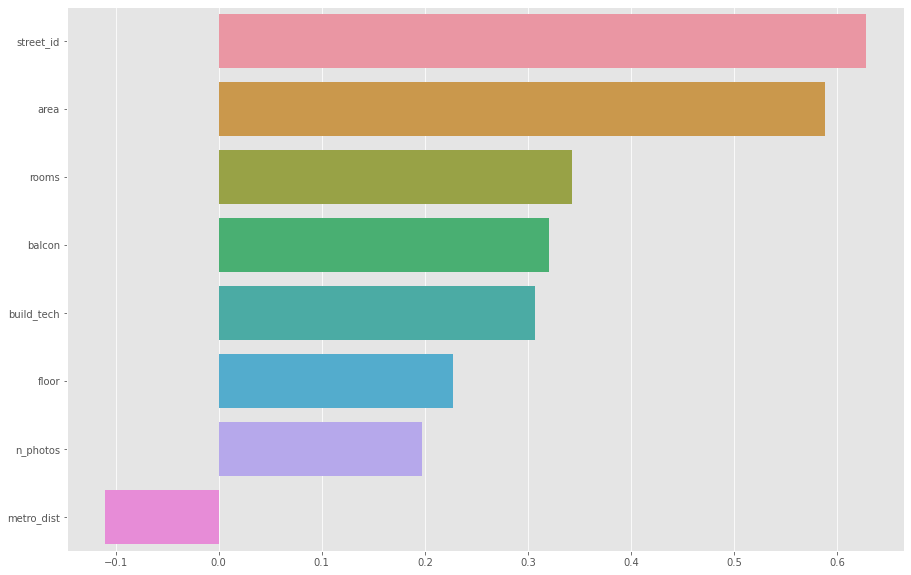

In [ ]:
correlations = train_df.drop(['price', 'id'], axis=1).corrwith(train_df.price).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Можно сделать вывод о том, что предположение сработало и теперь корреляция **street_id** и цены гораздо выше.

### То, что по какой-то неведомой причине работает и выдает относительно неплохие результаты на кегле (туда этот препроцессинг)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   date        100000 non-null  object 
 2   street_id   100000 non-null  int64  
 3   build_tech  70265 non-null   float64
 4   floor       100000 non-null  int64  
 5   area        100000 non-null  int64  
 6   rooms       100000 non-null  int64  
 7   balcon      100000 non-null  int64  
 8   metro_dist  95104 non-null   float64
 9   g_lift      70008 non-null   float64
 10  n_photos    100000 non-null  int64  
 11  kw1         100000 non-null  int64  
 12  kw2         100000 non-null  int64  
 13  kw3         100000 non-null  int64  
 14  kw4         100000 non-null  int64  
 15  kw5         100000 non-null  int64  
 16  kw6         100000 non-null  int64  
 17  kw7         100000 non-null  int64  
 18  kw8         100000 non-null  int64  
 19  kw9

Меняем *NaN* на медианное значение для **build_tech** и **g_lift** (поможет игнорировать выбросы и просто лучше для бинарных значений) и на среднее значение для **metro_dist** (практика показала что так работает лучше)

In [ ]:
train_df.build_tech = train_df.build_tech.fillna(train_df.build_tech.median()).astype('Int64')
test_df.build_tech = test_df.build_tech.fillna(test_df.build_tech.median()).astype('Int64')

train_df.g_lift = train_df.g_lift.fillna(train_df.g_lift.median()).astype('Int64')
test_df.g_lift = test_df.g_lift.fillna(test_df.g_lift.median()).astype('Int64')

train_df.metro_dist = train_df.metro_dist.fillna(train_df.metro_dist.mean())
test_df.metro_dist = test_df.metro_dist.fillna(test_df.metro_dist.mean())

Проверяем данные на выбросы

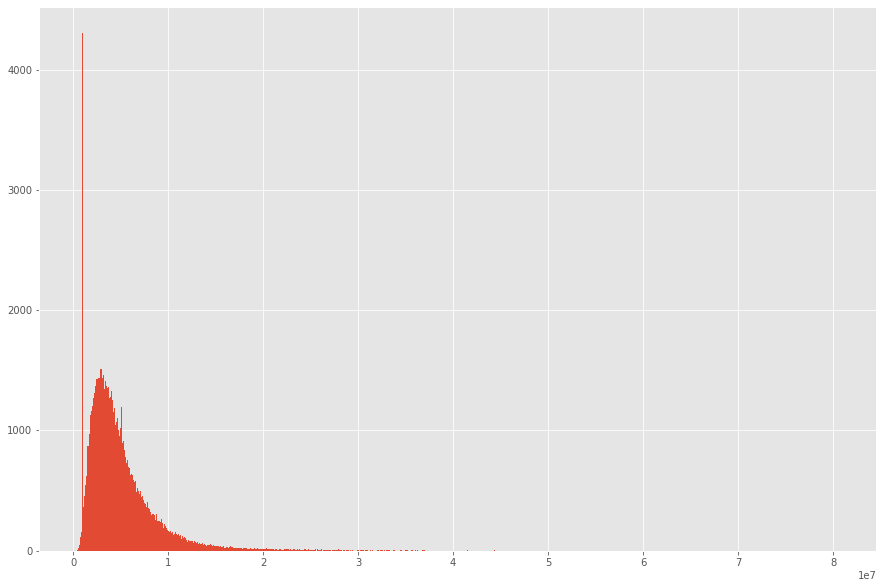

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(train_df.price, bins=1000);

По гистограме понятно, что присутсвует 2 выброса. Какая-то цена встречается слишком часто (найдем это значение и удалим его из выборки), а также обрежем хвост со слишком большими ценами (НЕ ОБРЕЖЕМ, поскольку это убьет скор на кегле).

In [ ]:
most_frequently_encountered = train_df.price.mode()[0]
print(f'Самое часто встречаемое значение: {most_frequently_encountered}')
train_df = train_df[train_df.price != most_frequently_encountered]

Самое часто встречаемое значение: 1000000


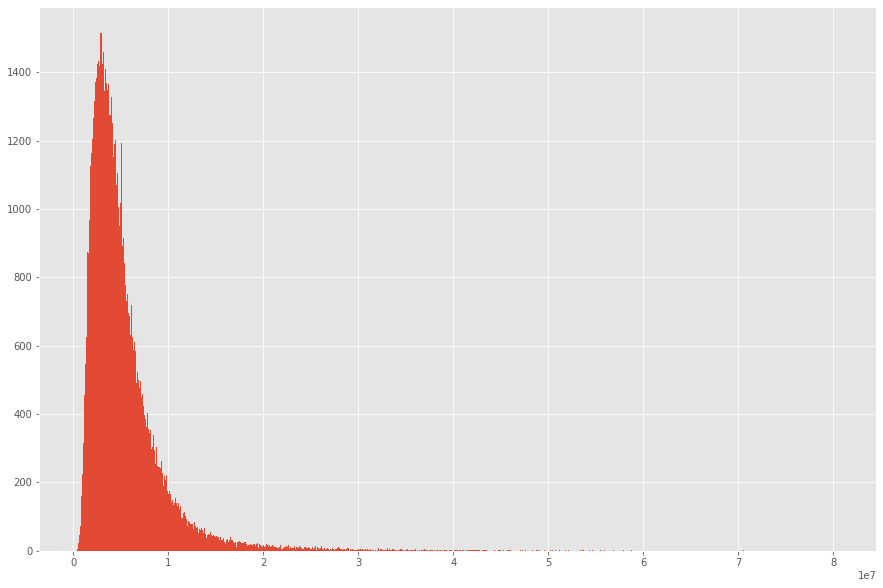

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(train_df.price, bins=1000);

Ну, хотя бы так

Далее (игноируя графики корреляций) удалим дату, поскольку она особо не влияет на цены за данный промежуток времени, а также количество фотографий (это уже с логической точки зрения). Все ключевые слова (о которых неизвестно ровным счетом ничего) и информацию о наличии лифта (возможно корреляция не дает полной картины) оставим.

In [ ]:
train_df = train_df.drop(['date', 'n_photos'], axis=1)
test_df = test_df.drop(['date', 'n_photos'], axis=1)

### Масштабирование и разделение на train/test

Отделяем метки от классов

In [ ]:
X_train = train_df.drop(['price', 'id'], axis=1)
X_test = test_df.drop(['id'], axis=1)
y = train_df.price

Отмасштабируем данные и добавим признаки с помощью полиномов 2-го порядка

In [ ]:
scaler = Pipeline([
    ('scaler_1', StandardScaler()),
    ('scaler_2', PolynomialFeatures(degree=2))
])

In [ ]:
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

Разобъем исходные данные на train/test для более качественной проверки результатов

In [ ]:
X_small_train, X_small_test, y_train, y_test = train_test_split(X_train_scal, y, test_size=0.15, random_state=42)

### Выбор параметров для классификаторов

Подбор параметров для первого классификатора

In [ ]:
clf = CatBoostRegressor(score_function='L2', n_estimators=300, random_state=24)

param = {'learning_rate': (0.2, 0.4, 0.6, 0.8),
         'reg_lambda': (10, 15, 20),
         'loss_function': ("MAE", "RMSE")}

gcv_model = GridSearchCV(clf, param, scoring='neg_mean_absolute_error', n_jobs=1, verbose=3)
gcv_model.fit(X_small_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
116:	learn: 1023772.7291446	total: 7.59s	remaining: 11.9s
117:	learn: 1022578.7571487	total: 7.66s	remaining: 11.8s
118:	learn: 1019944.7065631	total: 7.71s	remaining: 11.7s
119:	learn: 1018532.2561477	total: 7.76s	remaining: 11.6s
120:	learn: 1017854.4834630	total: 7.82s	remaining: 11.6s
121:	learn: 1015099.2862486	total: 7.88s	remaining: 11.5s
122:	learn: 1013496.6460776	total: 7.93s	remaining: 11.4s
123:	learn: 1006455.4831114	total: 8s	remaining: 11.4s
124:	learn: 1000235.9886526	total: 8.09s	remaining: 11.3s
125:	learn: 997708.7979827	total: 8.16s	remaining: 11.3s
126:	learn: 996936.7289850	total: 8.22s	remaining: 11.2s
127:	learn: 991507.8944503	total: 8.3s	remaining: 11.2s
128:	learn: 990794.0009275	total: 8.36s	remaining: 11.1s
129:	learn: 989649.1165364	total: 8.42s	remaining: 11s
130:	learn: 987823.3076724	total: 8.49s	remaining: 10.9s
131:	learn: 986911.6142578	total: 8.57s	remaining: 10.9s
132:	learn: 98570

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f4fb8458d90>,
             n_jobs=1,
             param_grid={'learning_rate': (0.2, 0.4, 0.6, 0.8),
                         'loss_function': ('MAE', 'RMSE'),
                         'reg_lambda': (10, 15, 20)},
             scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
model_cat = gcv_model.best_estimator_
print(f'Подобранные параметры: {gcv_model.best_params_}')

Подобранные параметры: {'learning_rate': 0.8, 'loss_function': 'RMSE', 'reg_lambda': 15}


Подбор параметров для второго классификатора

In [ ]:
clf = LGBMRegressor(reg_alpha=0.05, num_leaves=1024, random_state=42,
                    n_estimators=500)

param = {'learning_rate': (0.2, 0.5),
         'reg_lambda': (0.01, 0.1)}

gcv_model = RandomizedSearchCV(clf, param, scoring='neg_mean_absolute_error', n_jobs=1, verbose=3)
gcv_model.fit(X_small_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.2, reg_lambda=0.01;, score=-986840.424 total time= 3.2min
[CV 2/5] END learning_rate=0.2, reg_lambda=0.01;, score=-952998.280 total time= 3.2min
[CV 3/5] END learning_rate=0.2, reg_lambda=0.01;, score=-1015632.078 total time= 3.2min
[CV 4/5] END learning_rate=0.2, reg_lambda=0.01;, score=-1010718.359 total time= 3.2min
[CV 5/5] END learning_rate=0.2, reg_lambda=0.01;, score=-989865.121 total time= 3.2min
[CV 1/5] END learning_rate=0.2, reg_lambda=0.1;, score=-980226.636 total time= 3.2min
[CV 2/5] END learning_rate=0.2, reg_lambda=0.1;, score=-939936.616 total time= 3.2min
[CV 3/5] END learning_rate=0.2, reg_lambda=0.1;, score=-1009711.769 total time= 3.2min
[CV 4/5] END learning_rate=0.2, reg_lambda=0.1;, score=-1005799.722 total time= 3.2min
[CV 5/5] END learning_rate=0.2, reg_lambda=0.1;, score=-993592.838 total time= 3.2min
[CV 1/5] END learning_rate=0.5, reg_lambda=0.01;, score=-1137078.152 to

RandomizedSearchCV(estimator=LGBMRegressor(n_estimators=500, num_leaves=1024,
                                           random_state=42, reg_alpha=0.05),
                   n_jobs=1,
                   param_distributions={'learning_rate': (0.2, 0.5),
                                        'reg_lambda': (0.01, 0.1)},
                   scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
model_lgbmr = gcv_model.best_estimator_
print(f'Подобранные параметры: {gcv_model.best_params_}')

Подобранные параметры: {'reg_lambda': 0.1, 'learning_rate': 0.2}


Подбор параметров для третьего классификатора

In [ ]:
clf = XGBRegressor(objective='reg:squarederror', booster='gbtree',
                   colsample_bytree=0.5, colsample_bynode=0.5, 
                   colsample_bylevel=0.5, seed=42)

param = {'learning_rate': (0.2, 0.5, 0.8),
         'min_child_weight': (0.001, 0.005, 0.01),
         'n_estimators': (500, 1000)}

gcv_model = GridSearchCV(clf, param, scoring='neg_mean_absolute_error', n_jobs=1, verbose=3)
gcv_model.fit(X_small_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.2, min_child_weight=0.001, n_estimators=500;, score=-1200666.381 total time=  45.7s
[CV 2/5] END learning_rate=0.2, min_child_weight=0.001, n_estimators=500;, score=-1194027.658 total time=  45.3s
[CV 3/5] END learning_rate=0.2, min_child_weight=0.001, n_estimators=500;, score=-1241801.124 total time=  45.3s
[CV 4/5] END learning_rate=0.2, min_child_weight=0.001, n_estimators=500;, score=-1217998.753 total time=  45.3s
[CV 5/5] END learning_rate=0.2, min_child_weight=0.001, n_estimators=500;, score=-1234653.667 total time=  45.3s
[CV 1/5] END learning_rate=0.2, min_child_weight=0.001, n_estimators=1000;, score=-997672.258 total time= 1.5min
[CV 2/5] END learning_rate=0.2, min_child_weight=0.001, n_estimators=1000;, score=-993786.939 total time= 1.5min
[CV 3/5] END learning_rate=0.2, min_child_weight=0.001, n_estimators=1000;, score=-1016316.139 total time= 1.5min
[CV 4/5] END learning_rate=0.2, mi

GridSearchCV(estimator=XGBRegressor(colsample_bylevel=0.5, colsample_bynode=0.5,
                                    colsample_bytree=0.5,
                                    objective='reg:squarederror', seed=42),
             n_jobs=1,
             param_grid={'learning_rate': (0.2, 0.5, 0.8),
                         'min_child_weight': (0.001, 0.005, 0.01),
                         'n_estimators': (500, 1000)},
             scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
model_xgbr = gcv_model.best_estimator_
print(f'Подобранные параметры: {gcv_model.best_params_}')

Подобранные параметры: {'learning_rate': 0.8, 'min_child_weight': 0.001, 'n_estimators': 1000}


### Обучение и предсказание

Обучим модель с помощью простого голосования между тремя классификаторами

In [ ]:
XGBR = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, 
                        colsample_bynode=0.5, n_jobs=1, colsample_bylevel=0.5,
                        booster='gbtree', seed=42,
                        learning_rate=0.8, min_child_weight=0.001, n_estimators=1000)

LGBM = LGBMRegressor(random_state=42, reg_alpha=0.05, reg_lambda=0.1, 
                     n_estimators=500, learning_rate=0.2, num_leaves=1000)

catboost = CatBoostRegressor(score_function='L2', n_estimators=300, random_state=24,
                             learning_rate=0.8, loss_function='RMSE', reg_lambda=15)

In [ ]:
final_clf = VotingRegressor([('XGBR', XGBR), ('LGBMR', LGBM), ('catboost', catboost)])
final_clf.fit(X_small_train, y_train)

0:	learn: 2902198.8307608	total: 133ms	remaining: 39.8s
1:	learn: 2758284.3399593	total: 219ms	remaining: 32.6s
2:	learn: 2697271.7636336	total: 279ms	remaining: 27.6s
3:	learn: 2654677.3994736	total: 356ms	remaining: 26.4s
4:	learn: 2623405.1570249	total: 414ms	remaining: 24.4s
5:	learn: 2589951.6478947	total: 492ms	remaining: 24.1s
6:	learn: 2570816.6196953	total: 551ms	remaining: 23.1s
7:	learn: 2551520.1498275	total: 616ms	remaining: 22.5s
8:	learn: 2528569.8389600	total: 675ms	remaining: 21.8s
9:	learn: 2493752.9009831	total: 747ms	remaining: 21.7s
10:	learn: 2455621.0199273	total: 814ms	remaining: 21.4s
11:	learn: 2432596.8269053	total: 888ms	remaining: 21.3s
12:	learn: 2417129.7119719	total: 940ms	remaining: 20.7s
13:	learn: 2391893.2542644	total: 1.01s	remaining: 20.6s
14:	learn: 2352451.3621927	total: 1.09s	remaining: 20.8s
15:	learn: 2296991.0297697	total: 1.18s	remaining: 20.9s
16:	learn: 2277821.2802941	total: 1.24s	remaining: 20.6s
17:	learn: 2258217.5440148	total: 1.31s	r

VotingRegressor(estimators=[('XGBR',
                             XGBRegressor(colsample_bylevel=0.5,
                                          colsample_bynode=0.5,
                                          colsample_bytree=0.5,
                                          learning_rate=0.8,
                                          min_child_weight=0.001,
                                          n_estimators=1000,
                                          objective='reg:squarederror',
                                          seed=42)),
                            ('LGBMR',
                             LGBMRegressor(learning_rate=0.2, n_estimators=500,
                                           num_leaves=1000, random_state=42,
                                           reg_alpha=0.05, reg_lambda=0.1)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7ff66b0c8110>)])

In [ ]:
y_pred_test = final_clf.predict(X_small_test)
y_pred_train = final_clf.predict(X_small_train)

print(f'Test: {mae(y_test, y_pred_test)}, Train: {mae(y_train, y_pred_train)}')

Test: 752544.1925975113, Train: 439734.2591570607


In [ ]:
test_df["price"] = final_clf.predict(X_test_scal)

test_df[["id", "price"]].to_csv("/content/drive/MyDrive/hw_5_trenev.csv", index=False)

!cat /content/drive/MyDrive/hw_5_trenev.csv | head

id,price
100000,4096368.57835192
100001,4991827.60312635
100002,3716833.018392337
100003,4828860.494081974
100004,5676874.214451735
100005,6372501.3859649
100006,3930033.0692137484
100007,2939424.2139458
100008,3702436.7905296343
